In [126]:
%matplotlib inline
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.metrics as metrics

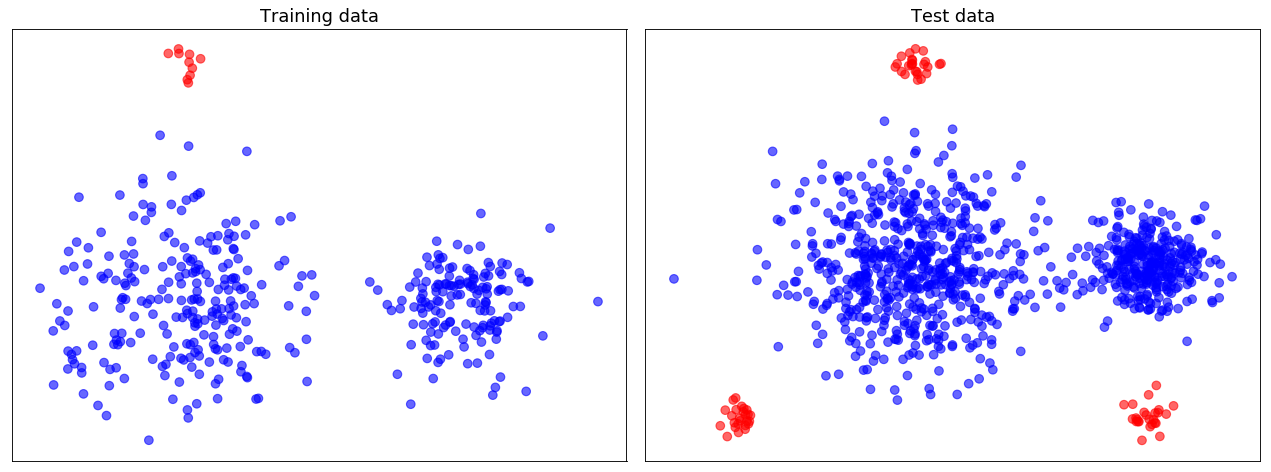

In [164]:
num_train_samples = 400
num_test_samples = 1000

a1 = np.random.randn(2, np.int(num_test_samples*0.025))*0.2
a2 = np.random.randn(2, np.int(num_test_samples*0.025))*0.2
a3 = np.random.randn(2, np.int(num_test_samples*0.025))*0.2
d1 = np.random.randn(2, np.int(num_test_samples*0.6))
n = num_test_samples - d1.shape[1] - a1.shape[1] - a2.shape[1] - a3.shape[1]
d2 = np.random.randn(2, n)*0.5

a1_ = np.random.randn(2, np.int(num_train_samples*0.025))*0.2
d1_ = np.random.randn(2, np.int(num_train_samples*0.6))
n = num_train_samples - d1_.shape[1] - a1_.shape[1]
d2_ = np.random.randn(2, n)*0.5

d2[0, :] += 4.
a1[1, :] += 4.
a2[0, :] += 4.
a3[0, :] -= 3.
a2[1, :] -= 3.
a3[1, :] -= 3.

d2_[0, :] += 4.
a1_[1, :] += 4.

num_train_anomalies = a1_.shape[1]
num_test_anomalies = a1.shape[1] + a2.shape[1] + a3.shape[1]

polluted_train_data = np.concatenate((a1_, d1_, d2_), axis=1)  
polluted_labels = np.zeros(polluted_train_data.shape[1], dtype=np.int)
polluted_labels[:num_train_anomalies] = 1

semi_supervised_train_data = np.concatenate((d1_, d2_), axis=1)  
test_data = np.concatenate((a1, a2, a3, d1, d2), axis=1) 
test_labels = np.zeros(test_data.shape[1], dtype=np.int)
test_labels[:num_test_anomalies] = 1

colors = np.array(['b', 'r'])
fig = plt.figure(figsize=(16, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.title('Training data', fontsize=16)
plt.scatter(polluted_train_data[0, :], polluted_train_data[1, :], 60, colors[polluted_labels], alpha=0.6)
plt.grid()
plt.xticks([], [], fontsize=14)
plt.yticks([], [], fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(test_data[0, :], test_data[1, :], 60, colors[test_labels], alpha=0.6)
plt.title('Test data', fontsize=16)
plt.grid()
plt.xticks([], [], fontsize=14)
plt.yticks([], [], fontsize=14)

fig.tight_layout()
plt.savefig('anomaly_detection_learning_setting.pdf')

1.0
0.7551282051282051


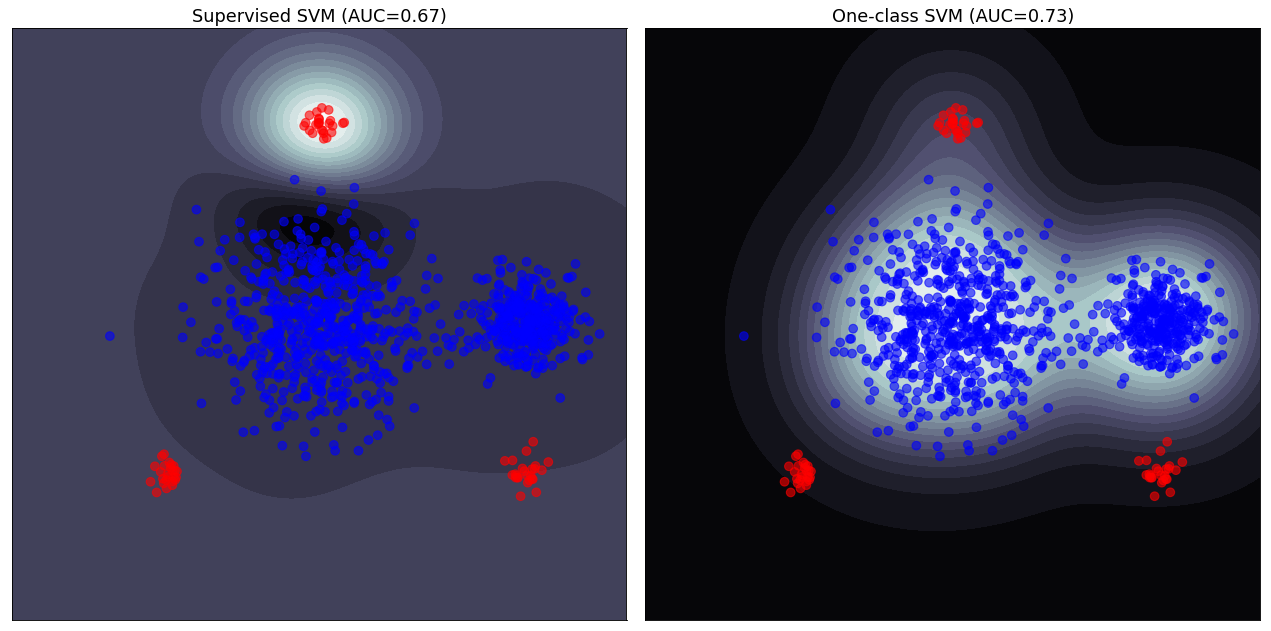

In [165]:
binary_classifier = svm.SVC() 
binary_classifier.fit(polluted_train_data.T, polluted_labels)

oneclass_classifier = svm.OneClassSVM()
oneclass_classifier.fit(polluted_train_data.T)

train_pred = binary_classifier.predict(polluted_train_data.T)
print(metrics.roc_auc_score(polluted_labels, train_pred))
train_pred = oneclass_classifier.predict(polluted_train_data.T)
print(metrics.roc_auc_score(polluted_labels, -train_pred))

test_pred = binary_classifier.predict(test_data.T)
svm_auc = metrics.roc_auc_score(test_labels, test_pred)
test_pred = oneclass_classifier.predict(test_data.T)
ocsvm_auc = metrics.roc_auc_score(test_labels, -test_pred)

delta = 0.025
x = np.arange(-6.0, 6.0, delta)
y = np.arange(-6.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
dx = np.reshape(X, (1, X.size))
dy = np.reshape(Y, (1, Y.size))
binary_dz = binary_classifier.decision_function(np.concatenate((dx, dy), axis=0).T)
oneclass_dz = oneclass_classifier.decision_function(np.concatenate((dx, dy), axis=0).T)
bZ = np.reshape(binary_dz, X.shape)
ocZ = np.reshape(oneclass_dz, X.shape)


fig = plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
CS = plt.contourf(X, Y, bZ, 20, cmap='bone')
# CS = plt.contour(X, Y, Z, [0.0, 0.5, 1.0], cmap='gray')
plt.scatter(test_data[0, :], test_data[1, :], 60, colors[test_labels], alpha=0.6)
plt.title('Supervised SVM (AUC={0:1.2f})'.format(svm_auc), fontsize=16)
plt.grid()
plt.xticks([], [], fontsize=14)
plt.yticks([], [], fontsize=14)

plt.subplot(1, 2, 2)
CS = plt.contourf(X, Y, ocZ, 20, cmap='bone')
# CS = plt.contour(X, Y, Z, [0.0, 0.5, 1.0], cmap='gray')
plt.scatter(test_data[0, :], test_data[1, :], 60, colors[test_labels], alpha=0.6)
plt.title('One-class SVM (AUC={0:1.2f})'.format(ocsvm_auc), fontsize=16)
plt.grid()
plt.xticks([], [], fontsize=14)
plt.yticks([], [], fontsize=14)

fig.tight_layout()
plt.savefig('supervised_vs_unsupervised.pdf')